## Introduction to SciBmad  

Differentiable simulation codes are necessary tools in accelerator physics to properly compute (via integration) Taylor maps representing the particle transport, and subsequently extract the lattice functions from. Early examples of differentiable accelerator physics codes are the Polymorphic Tracking Code (PTC) and COSY-INFINITY, both developed in the early 1990s.

`SciBmad` is a new, modular, polymorphic, differentiable, and portable (CPU/GPU compatible) accelerator physics code being developed at Cornell. This Jupyter notebook will show some its basic features, including lazily evaluated deferred expressions, polymorphism, and differentiability.

In [ ]:
# Skip this step if you already installed SciBmad
# import Pkg; Pkg.add("SciBmad")

# To update, go through Julia's regular package updating mechanism:
# Pkg.update()

In [1]:
using SciBmad

Let's first make a FODO cell consisting of a quadrupole, sextupole, bend, and drift. This uses the [`Beamlines.jl`](https://github.com/bmad-sim/Beamlines.jl) package within the SciBmad family, which is automatically included when `using SciBmad`. We require by design that the focusing quadrupole strength is negative that of the defocusing quadrupole strength, and likewise for the sextupole. To achieve this, we will use `SciBmad`'s deferred expressions

In [2]:
# Make a FODO cell requiring that
# qf.Kn1 = -qd.Kn1 
# and
# sf.Kn2 = -sd.Kn2
# This is done using a "deferred expression"
# to form a "closure" of the variables we define:

K1 = 0.36;
K2 = 0.1;

qf = Quadrupole(Kn1=DefExpr(() -> +K1), L=0.5);
sf = Sextupole(Kn2=DefExpr(() -> +K2), L=0.2);
d  = Drift(L=0.6);
b  = SBend(L=6.0, angle=pi/132);
qd = Quadrupole(Kn1=DefExpr(() -> -K1), L=0.5);
sd = Sextupole(Kn2=DefExpr(() -> -K2), L=0.2);


fodo_line = [qf, sf, d, b, d, qd, sd, d, b, d];
fodo = Beamline(fodo_line, species_ref=Species("electron"), E_ref=18e9);

Now if we update `K1`, both `qf` and `qd` will be (lazily) updated.

In [3]:
K1 = 0.3
println(qf.Kn1)
println(qd.Kn1)

0.3
-0.3


We can get the Twiss parameters using `twiss` 

In [4]:
t = twiss(fodo)

Table with 23 columns and 11 rows:
      s     phi_1       beta_1   alpha_1    phi_2      beta_2   alpha_2    ⋯
    ┌───────────────────────────────────────────────────────────────────────
 1  │ 0.0   0.0         25.7461  -1.9335    0.0        7.21098  0.572616   ⋯
 2  │ 0.5   0.00305255  25.7461  1.93356    0.0111833  7.21098  -0.572616  ⋯
 3  │ 0.7   0.00430772  24.98    1.89675    0.0155274  7.44739  -0.609446  ⋯
 4  │ 1.3   0.00831212  22.7702  1.78632    0.0277257  8.24502  -0.719935  ⋯
 5  │ 7.3   0.0818501   7.95426  0.68254    0.0986311  23.5136  -1.82482   ⋯
 6  │ 7.9   0.0944804   7.20156  0.571968   0.102511   25.7697  -1.93531   ⋯
 7  │ 8.4   0.105678    7.20155  -0.571951  0.105561   25.7697  1.93531    ⋯
 8  │ 8.6   0.110028    7.4377   -0.608808  0.106815   25.0029  1.89848    ⋯
 9  │ 9.2   0.122242    8.23461  -0.719378  0.110815   22.791   1.78799    ⋯
 10 │ 15.2  0.193223    23.4922  -1.82307   0.184274   7.96441  0.683105   ⋯
 11 │ 15.8  0.197106    25.7461  -1.9335 

We can use any plotting package in Julia to make plots, e.g. of the beta functions. The "fastest" one is `Plots.jl`. 

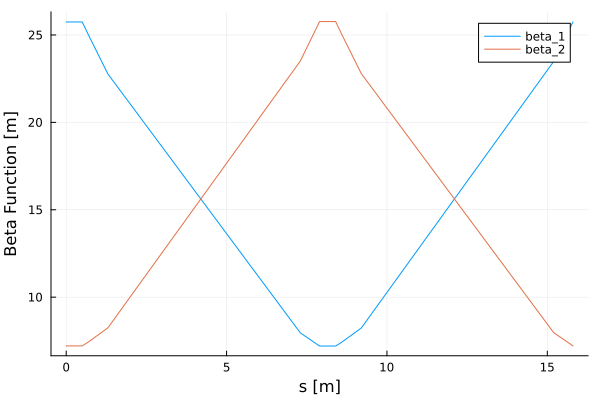

In [5]:
# import Pkg; Pkg.add("Plots")
using Plots
plt = plot()
plot!(plt, t.s, t.beta_1, label="beta_1")
plot!(plt, t.s, t.beta_2, label="beta_2")
xlabel!(plt, "s [m]")
ylabel!(plt, "Beta Function [m]")
display(plt)

Other more powerful plotting packages are CairoMakie, GLMakie, WGLMakie. Reminder: Julia is a "just-in-time" (JIT) compiled language, meaning that functions may have to be compiled at the first call, but then will be fast for all subsequent calls in the same session. `SciBmad` has precompiled common workflows to minimize this JIT-latency for most users, but you should be aware that some first-calls may be still be "slow" in a given Julia session, even though subsequent calls will be compiled and fast. If you would like, compiled workflows can be preserved for future Julia sessions using the [`PackageCompiler.jl`](https://julialang.github.io/PackageCompiler.jl/stable/) package.

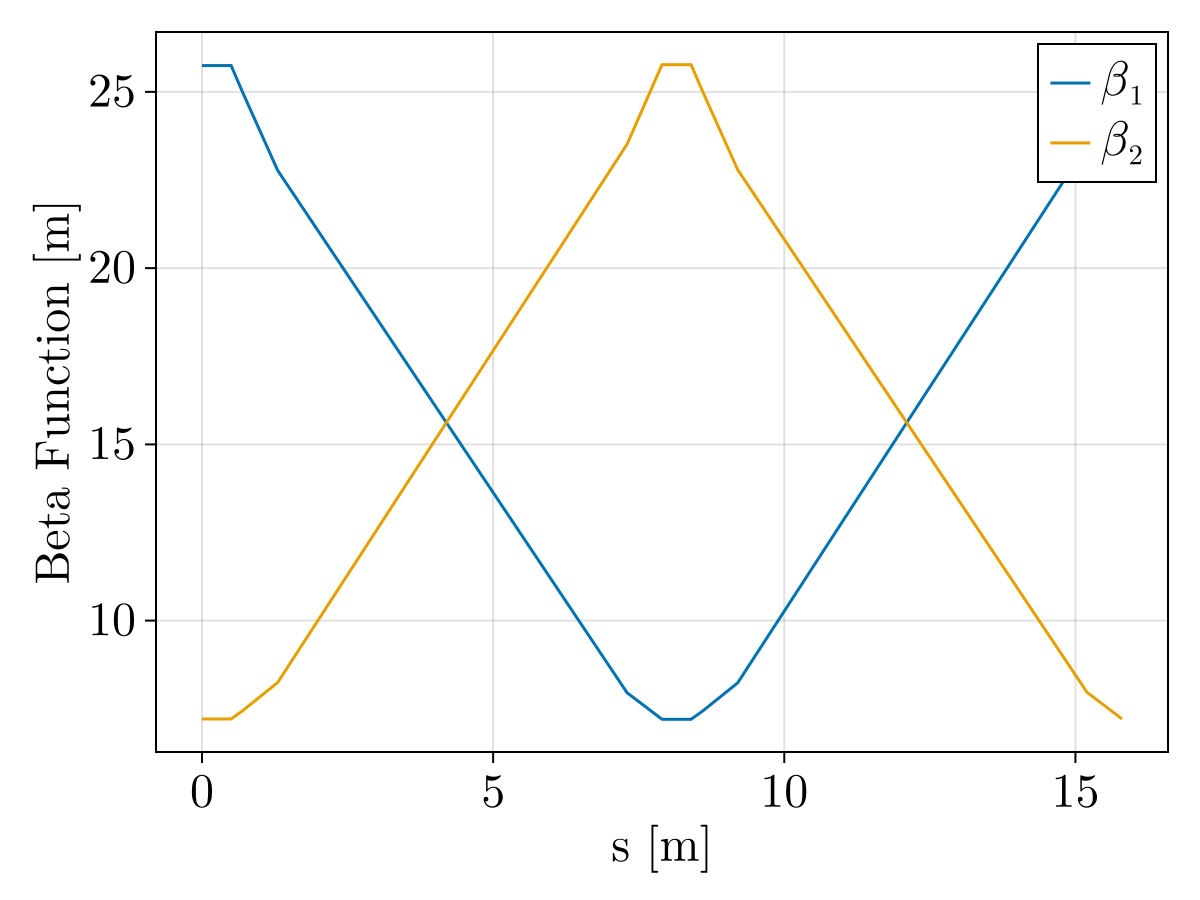

In [6]:
# Pkg.add("CairoMakie") # More powerful plotting package
# Pkg.add("LaTeXStrings") # For plotting with LaTeX formatting
using CairoMakie: CairoMakie as CM
using LaTeXStrings
CM.with_theme(CM.theme_latexfonts()) do
    f = CM.Figure(fontsize=24);
    ax = CM.Axis(f[1, 1], xlabel="s [m]", ylabel="Beta Function [m]");
    CM.lines!(ax, t.s, t.beta_1, label=L"\beta_1"); # L".." specifies a LaTeX string
    CM.lines!(ax, t.s, t.beta_2, label=L"\beta_2");
    CM.axislegend(position=:rt);
    CM.display(f);
end;

Let's compute the transport matrix for this FODO cell using automatic differentiation (AD). Because it is a periodic (closed) geometry, need to expand around the closed orbit. The closed orbit is computed in the `twiss` call

In [7]:
co = [t.orbit_x[1], t.orbit_px[1], t.orbit_y[1], t.orbit_py[1], t.orbit_z[1], t.orbit_pz[1]]

6-element Vector{Float64}:
 -1.6514567491299204e-16
 -2.0816681711721685e-17
 -6.197220762437987e-33
 -3.8662026140340404e-33
  3.552713678800501e-15
  0.0

We see that in this case the closed orbit is the "zero orbit", which makes sense because all the magnets are perfectly aligned and there are no RF cavities. Note that in general the "zero orbit" is not always the closed orbit (in the case of a periodic accelerator) or the reference orbit (in the case of a linac). We must always expand around some real trajectory.

Now we will use [`GTPSA.jl`](https://github.com/bmad-sim/GTPSA.jl) to compute the Taylor map, to 2nd order. `GTPSA.jl` is a full-featured interface to the Generalised Truncated Power Series Algebra library, written by Laurent Deniau for CERN's `MAD-NG` code, and is another package in the `SciBmad` family. Because `SciBmad` is polymorphic, all we need to do is track a single particle on the closed orbit where the numbers are Truncated Power Series (`TPS`) types instead of the regular 64-bit floats `Float64`s.

First, we define a `Descriptor` to define the number of variables (6) and the truncation order of our Taylor series (2).

In [8]:
D2 = Descriptor(6, 2) # 6 variables, 2nd order

Descriptor(NV=6, MO=2)

We will then get our special `TPS` number types. Specifically, we will start with the "identity map", or a vector of unit "wiggles". E.g., wiggle the input a bit, see how the output wiggles

In [9]:
# Then get a vector of `TPS`s representing an identity of the variables:
dv = vars(D2) # Think of these as unit "wiggles"

 # Finally initialize our particle coordinates
v0 = zeros(6) # Closed orbit
v = v0 + dv   # Particle as a TPSA (wiggle around the closed orbit)

6-element Vector{TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=2)
 Index Coefficient                Order   Exponent
--------------------------------------------------------------------
   1:   1.0000000000000000e+00      1      1   0   0   0   0   0
--------------------------------------------------------------------
   2:   1.0000000000000000e+00      1      0   1   0   0   0   0
--------------------------------------------------------------------
   3:   1.0000000000000000e+00      1      0   0   1   0   0   0
--------------------------------------------------------------------
   4:   1.0000000000000000e+00      1      0   0   0   1   0   0
--------------------------------------------------------------------
   5:   1.0000000000000000e+00      1      0   0   0   0   1   0
--------------------------------------------------------------------
   6:   1.0000000000000000e+00      1      0   0   0   0   0   1


Now we track!

In [10]:
b0 = Bunch(v)
track!(b0, fodo)  # b0 is mutated in-place with the result
println(b0.coords.v)

Setting bunch.species = Species(electron), charge=-1.0e, mass=510998.95069 eV/c², spin=0.5ħ) (reference species from the Beamline)
Setting bunch.R_ref = -60.04153711147289 (reference R_ref from the Beamline)
6-element Matrix{TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=2)
 Index Coefficient                Order   Exponent
--------------------------------------------------------------------
   1:   2.5673907444456746e-17      0      0   0   0   0   0   0
   1:  -1.5014406748569311e+00      1      1   0   0   0   0   0
   1:   2.4337323961276102e+01      1      0   1   0   0   0   0
   1:   1.1205958985068023e-15      1      0   0   1   0   0   0
   1:   4.3016186378763006e-15      1      0   0   0   1   0   0
   1:   4.6559967240029498e-01      1      0   0   0   0   0   1
   1:  -2.1627933897208906e-01      2      2   0   0   0   0   0
   1:  -5.9709393739610006e-01      2      1   1   0   0   0   0
   1:   6.0038236574563868e+00      2      0   2   0   0   0   0
   1:   7.34479353103971

This is the real nonlinear Taylor map, computed from the integrator itself - no matrix or map is stored internally.

The exponent specifies the power of each variable, e.g. the last row in `1: ...` corresponds to $\delta^2$ - it defines how $x$ depends on $\delta^2$.

We can also get the linear part (as a matrix):

In [11]:
# We can clean up the output with
GTPSA.show_eps = 1e-10

# Also print the matrix (linear part)
GTPSA.jacobian(b0.coords.v)

6×6 Matrix{Float64}:
 -1.50144      24.3373        1.1206e-15    4.30162e-15  0.0   0.4656
 -0.173973      2.15396       1.46476e-16   5.62357e-16  0.0   0.0614828
 -8.67666e-17   4.00294e-15   0.868579      6.81317      0.0   4.66602e-17
 -1.13689e-17   5.23435e-16  -0.173989     -0.213474     0.0   6.10369e-18
  0.0113111    -0.493447     -1.41183e-17  -5.41886e-17  1.0  -0.00694548
  0.0           0.0           0.0           0.0          0.0   1.0

To get the tunes, we need to go to the normal form, where the motion lies on circles in phase space with tunes as functions of solely the radius of the circle (amplitude-dependent rotations). E.g. we seek a nonlinear map $\vec{a}$ such that $\vec{r} = \vec{a}^{-1}\circ\vec{m}\circ\vec{a}$ where $\vec{m}$ is the one-turn map. $\vec{r}$ will then, being in circle world, have the form

$$
\begin{equation}
    \begin{pmatrix}
        \bar{q}_1 \\ \bar{p}_1 \\ \vdots \\ \bar{q}_n \\ \bar{p}_n
    \end{pmatrix}_{t_0+T} = 
    \underbrace{\begin{pmatrix}
        \mathsf{R}(\mu_i(\vec{J})) & \mathsf{0} & \mathsf{0} \\
        \mathsf{0} & \ddots & \mathsf{0}\\
        \mathsf{0} & \mathsf{0} & \mathsf{R}(\mu_n(\vec{J}))
    \end{pmatrix}}_{\let\scriptstyle\textstyle\substack{\vec{r}}}
\begin{pmatrix}
        \bar{q}_1 \\ \bar{p}_1 \\ \vdots \\ \bar{q}_n \\ \bar{p}_n
    \end{pmatrix}_{t_0},\ \  \mathsf{R}(\alpha)= \begin{pmatrix}
        \cos{\alpha} && \sin{\alpha} \\
        -\sin{\alpha} && \cos{\alpha}
    \end{pmatrix} \ .
\end{equation}
$$

where $(\bar{q}_1,\bar{p}_1) = (\sqrt{2J_1}\cos{\phi_1},\sqrt{2J_1}\sin{\phi_1})$.

`SciBmad`'s `NonlinearNormalForm.jl` package makes it very easy to compute `a`, with a single function `normal`. We will elevate the tracking map result to a bona-fide `DAMap` (differential algebraic map) type, and then compute `a`:

In [12]:
m = DAMap(v=b0.coords.v)
a = normal(m)

DAMap{StaticArraysCore.MVector{5, Float64}, StaticArraysCore.MVector{6, TPS64{GTPSA.Dynamic}}, Nothing, Nothing}([0.0, 0.0, 0.0, 0.0, 0.0], 6-element StaticArraysCore.MVector{6, TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=2)
 Index Coefficient                Order   Exponent
--------------------------------------------------------------------
   1:  -5.0740641298145190e+00      1      0   1   0   0   0   0
   1:   7.1173080782843934e-01      1      0   0   0   0   0   1
   1:  -3.2441446714466489e+00      2      2   0   0   0   0   0
   1:  -1.0580574636488713e-01      2      1   1   0   0   0   0
   1:  -6.2956604413946704e-01      2      0   2   0   0   0   0
   1:  -7.7843147822245873e-01      2      0   0   2   0   0   0
   1:   2.0150363722831105e-01      2      0   0   1   1   0   0
   1:  -9.4868239203552862e-01      2      0   0   0   2   0   0
   1:   4.0766503649414232e-01      2      1   0   0   0   0   1
   1:   2.2525201966597836e+00      2      0   1   0   0   0   1
   1: 

We now can compute the nonlinear rotation $\vec{r}$:

In [13]:
ai = inv(a)
r = ai * m * a
GTPSA.jacobian(r.v)

6×6 Matrix{Float64}:
  0.326257      0.945281     -8.64701e-16   2.75229e-16  0.0   1.66533e-16
 -0.945281      0.326257      9.86076e-32  -9.86076e-32  0.0  -4.16334e-17
 -8.83524e-29  -2.52435e-29   0.327553      0.944833     0.0  -1.26218e-29
  0.0          -7.57306e-29  -0.944833      0.327553     0.0   2.20881e-29
 -6.66134e-16  -3.33501e-16   1.35585e-31  -1.10934e-31  1.0  -0.0255521
  0.0           0.0           0.0           0.0          0.0   1.0

It is easiest to view this in the complex phasors basis where the coordinates are $(\tilde{q}_i,\tilde{p}_i)=(\sqrt{J_i}e^{+\textrm{i}\phi_i},\sqrt{J_i}e^{-\textrm{i}\phi_i})$. That way, we see explicitly that the monomials $(\tilde{q}_i\tilde{p}_i)^n = J_i^n$.

In [14]:
c = c_map(m)
ci = inv(c)
r_phasor = ci * r * c
print(r_phasor)

DAMap{StaticArraysCore.MVector{5, ComplexF64}, StaticArraysCore.MVector{6, ComplexTPS64{GTPSA.Dynamic}}, Nothing, Nothing}(ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 6-element StaticArraysCore.MVector{6, ComplexTPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=2)
 Index Real                     Imag                       Order   Exponent
---------------------------------------------------------------------------------------------
   1:   3.2625736656277743e-01  -9.4528097979570380e-01      1      1   0   0   0   0   0
   1:   1.1996770798030458e+00   4.1406046789056716e-01      2      1   0   0   0   0   1
---------------------------------------------------------------------------------------------
   2:   3.2625736656277743e-01   9.4528097979570380e-01      1      0   1   0   0   0   0
   2:   1.1996770798030458e+00  -4.1406046789056716e-01      2      0   1   0   0   0   1
-------------------------------------------------------------------------------------

Note that this map, which is a rotation, is in the phasors basis. So, $\tilde{q}_1 = \sqrt{J}e^{\textrm{i}\phi_1}$. In the linear case we have

$$
\tilde{q}_1 ∘ \vec{r}_{phasor,linear} = \underbrace{\sqrt{J}e^{\textrm{i}\phi_1}}_{\tilde{q}_1}e^{-\textrm{i}2\pi\nu_{1}} = \sqrt{J}e^{\textrm{i}(\phi_1 - 2\pi\nu_{1})} \ .
$$
This makes sense - it rotators phase. In the nonlinear case we see that we have

$$
\tilde{q}_1 ∘ \vec{r}_{phasor} = \sqrt{J}e^{\textrm{i}\phi_1}e^{-\textrm{i}2\pi\left(\nu_{1}+\xi_x\delta\right)}
$$

We can remove the $\sqrt{J}e^{\textrm{i}\phi_1}$ using `par` in `GTPSA`, specifying to remove the first variable. Then we can naturally compute the amplitude-dependent tune

In [15]:
ADT = real(-log(par(r_phasor.v[1], 1))/(2*pi*im))
ADT

TPS64{GTPSA.Dynamic}:
Descriptor(NV=6, MO=2)
 Coefficient                Order   Exponent
  1.9710619563624476e-01      0      0   0   0   0   0   0
 -2.0198707204070696e-01      1      0   0   0   0   0   1


With a differentiable code, we can trivially extract things like the chromaticity, and get exact solutions given the physics of the tracking code - no nasty equations or integrals.

Not only is differentiability necessary to compute and analyze high order Taylor maps, it also allows us to compute exact derivatives of anything we want. This includes the parameters, e.g. the quadrupole strengths. Using `SciBmad`, we can compute the tune $\nu_x$ as a function of variations in the quadrupole strength, e.g. $\nu=\nu(\Delta K_{n1})$